In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
!pip install rarfile

In [ ]:
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image
# Download the RAR file

#https://drive.google.com/file/d/1xdkdeikXgTfX1JA51klhgamLPx9byKZR/view?usp=drive_link
url = 'https://drive.google.com/uc?id=1IR_qVQ2Xmx-d37ROiOuTyh8l56eOlOGX'
#https://drive.google.com/file/d/1xdkdeikXgTfX1JA51klhgamLPx9byKZR/view?usp=sharing
output_rar = '/content/New_Combined_Dataset_Split1.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')

Downloading...
From (original): https://drive.google.com/uc?id=1IR_qVQ2Xmx-d37ROiOuTyh8l56eOlOGX
From (redirected): https://drive.google.com/uc?id=1IR_qVQ2Xmx-d37ROiOuTyh8l56eOlOGX&confirm=t&uuid=dfefe81c-c8f1-4711-9868-24f040e0cd96
To: /content/New_Combined_Dataset_Split1.rar
100%|██████████| 84.2M/84.2M [00:01<00:00, 48.8MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
    GlobalAveragePooling2D, Dense, concatenate, AveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Dataset path
data_dir = "/content/New_Combined_Dataset_Split1"  # Corrected dataset path

# Define Swish Activation
def swish(x):
    return x * tf.nn.sigmoid(x)

# Define a Dense Block
def dense_block(x, num_layers, growth_rate, activation=swish):
    for _ in range(num_layers):
        # Bottleneck Layer
        bn = BatchNormalization()(x)
        act = Activation(activation)(bn)
        conv = Conv2D(4 * growth_rate, (1, 1), padding='same', kernel_initializer='he_normal')(act)

        # 3x3 Convolution Layer
        bn = BatchNormalization()(conv)
        act = Activation(activation)(bn)
        conv = Conv2D(growth_rate, (3, 3), padding='same', kernel_initializer='he_normal')(act)

        # Concatenate
        x = concatenate([x, conv])
    return x

# Transition Block
def transition_block(x, compression=0.5, activation=swish):
    num_filters = int(tf.keras.backend.int_shape(x)[-1] * compression)
    bn = BatchNormalization()(x)
    act = Activation(activation)(bn)
    conv = Conv2D(num_filters, (1, 1), padding='same', kernel_initializer='he_normal')(act)
    x = AveragePooling2D((2, 2), strides=2, padding='same')(conv)
    return x

# Build DenseNet Model
def build_densenet(input_shape, num_classes, num_blocks=3, growth_rate=32, num_layers_per_block=4, activation=swish):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Blocks with Transition Layers
    for _ in range(num_blocks - 1):
        x = dense_block(x, num_layers=num_layers_per_block, growth_rate=growth_rate, activation=activation)
        x = transition_block(x, compression=0.5, activation=activation)

    # Final Dense Block
    x = dense_block(x, num_layers=num_layers_per_block, growth_rate=growth_rate, activation=activation)

    # Classification Head
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Define parameters for DenseNet
input_shape = (224, 224, 3)  # Define the input shape for your X-ray images
num_classes = 5  # For binary classification (e.g., NORMAL vs. PNEUMONIA)
model = build_densenet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      8,320 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,896 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     12,416 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 727,365 (2.77 MB)

 Trainable params: 719,525 (2.74 MB)

 Non-trainable params: 7,840 (30.62 KB)

Found 8016 images belonging to 5 classes.
Found 1144 images belonging to 5 classes.
Found 2293 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 105s 212ms/step - accuracy: 0.6935 - loss: 0.8006 - val_accuracy: 0.5953 - val_loss: 5.3881
Epoch 2/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.8640 - loss: 0.3729 - val_accuracy: 0.4694 - val_loss: 8.6828
Epoch 3/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.8854 - loss: 0.3071 - val_accuracy: 0.6486 - val_loss: 1.7604
Epoch 4/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.9078 - loss: 0.2529 - val_accuracy: 0.8531 - val_loss: 0.3421
Epoch 5/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.9242 - loss: 0.2105 - val_accuracy: 0.8156 - val_loss: 0.4491
Epoch 6/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.9452 - loss: 0.1607 - val_accuracy: 0.7456 - val_loss: 3.2800
Epoch 7/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.9479 - loss: 0.1435 - val_accuracy: 0.7168 - val_loss: 4.3675
Epoch 8/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.9562 - loss: 

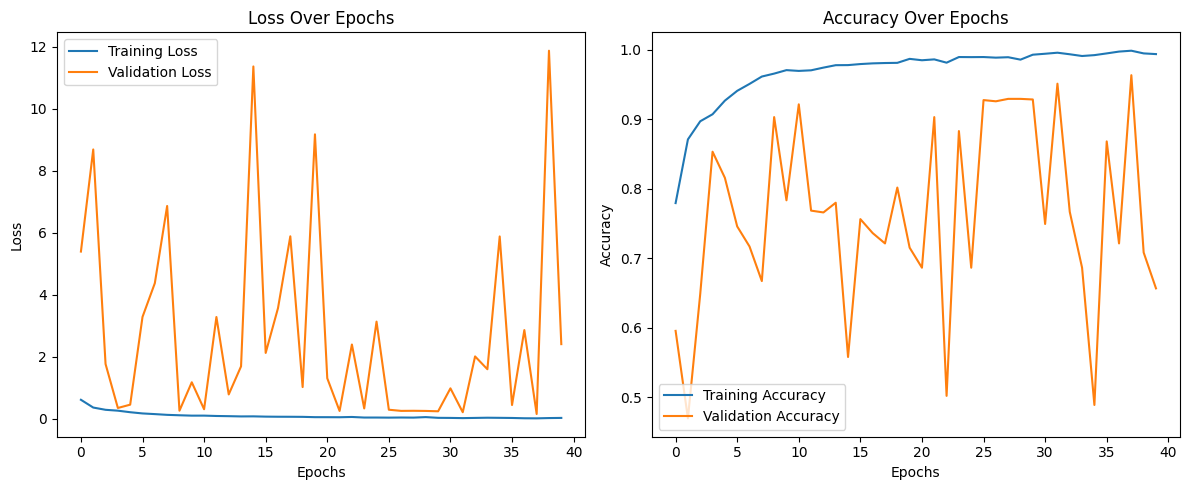

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step

Performance on Test Data
Precision: 0.5675876756863856
Recall: 0.6524204099433057
F1 Score: 0.5825827297475381
Accuracy: 0.6524204099433057
Confusion Matrix:
                Benign  Malignant  Normal  Pneumonia  Not_pridicted
Benign             96          0      16          8              0
Malignant          83          0     457         22              0
Normal             11          0     704         13              5
Pneumonia           1          0       3         18              1
Not_pridicted       0          0     146         31            678


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Train the model
history = model.fit(train_generator, epochs=40, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Evaluation function
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Evaluate the model
evaluate_model(test_generator, model, ['Benign', 'Malignant', 'Normal', 'Pneumonia', 'Not_pridicted'], title="Performance on Test Data")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_heatmap(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plots a confusion matrix as a heatmap.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        class_names (list): List of class names.
        title (str): Title of the heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_heatmap(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plots a confusion matrix as a heatmap.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        class_names (list): List of class names.
        title (str): Title of the heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()

SyntaxError: invalid syntax (<ipython-input-10-03ffb235430e>, line 27)

In [ ]:
# Save the trained model to an HDF5 file
model.save('Densnet_upd_mcnn_trained_model.h5')

In [ ]:
from google.colab import files

# Download the .h5 file
files.download('Densnet_upd_mcnn_trained_model.h5')

